In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Problem2

In [154]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']
data_nb = pd.concat([X, y], axis=1)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of data: ", data_nb.shape)
print("Distribution of label: \n", y.value_counts())

Shape of X:  (4600, 54)
Shape of y:  (4600, 1)
Shape of data:  (4600, 55)
Distribution of label: 
 target
0         2787
1         1813
dtype: int64


In [155]:
### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index().iloc[:,1:]
### Partition Data
data_cv = np.array_split(data_temp, 10)

In [156]:
class Naive_Bayers:
    def __init__(self) -> None:
        None

    def fit(self, X, y):
        self.n, self.m = X.shape
        self.pi = y.sum()/y.shape[0]
        self.lambda_0 = (1 + X[y == 0].sum(axis = 0))/(1 + y.shape[0] - y.sum())
        self.lambda_0 = self.lambda_0
        self.lambda_1 = (1 + X[y == 1].sum(axis = 0))/(1 + y.sum())
        self.lambda_1 = self.lambda_1
    
    def predict(self, X):
        # print('X: ', X.shape)
        # print('lambda0: ', self.lambda_0.shape)
        # print(np.sum(X*np.log(self.lambda_1.T), axis=1))

        p0 = (np.log(1-self.pi) + np.sum(X*np.log(self.lambda_0.T), axis=1) - np.sum(self.lambda_0)).reset_index(drop=True)
        p1 = (np.log(self.pi) + np.sum(X*np.log(self.lambda_1.T), axis=1) - np.sum(self.lambda_1)).reset_index(drop=True)
        result = pd.Series([0 if p0[i] > p1[i] else 1 for i in range(len(p0))])
        return result
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()

        y_TN = ((y_true == 0) & (y_predict == 0)).sum()
        y_FP = ((y_true == 0) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == 0)).sum()
        return y_TP, y_TN, y_FP, y_FN
    
    def get_lambda(self):
        return self.lambda_0, self.lambda_1

### (a)

In [157]:
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    predicted_result = nb_model.predict(X_test)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, predicted_result)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))


-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1714            490 
 Predicted 0      99             2297 
-------------------------------------


In [158]:
print()

### (b)

In [159]:
lambda0, lambda1 = 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    l0, l1 = nb_model.get_lambda()
    lambda0 += l0
    lambda1 += l1
lambda0 /= 10
lambda1 /= 10

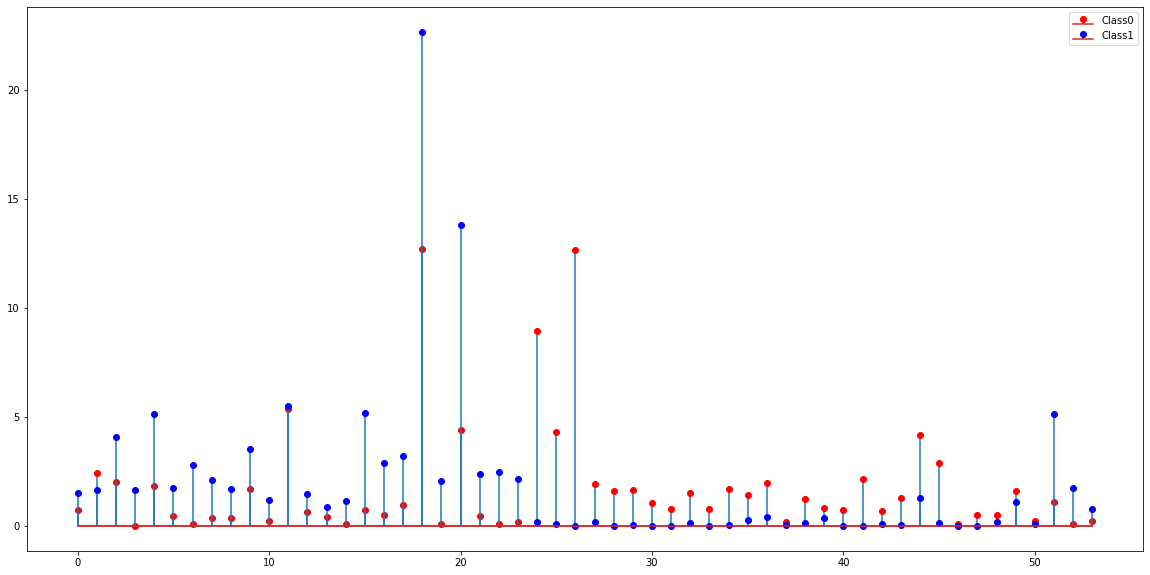

In [160]:
fig = plt.figure(figsize=(20,10))
plt.stem(lambda0.index, lambda0, label='Class0', markerfmt='ro')
plt.stem(lambda0.index, lambda1, label='Class1', markerfmt='bo')
plt.legend()
plt.show()

In feature 16 and 52 both have a higher value of lambda in class 1 and much lower value of lambda in class0, which means that the email contains "free" and "!" has a higher chance to be classified as a spam email.

In [161]:
# Feature16
print('Feature 16: Free, ', 'Class 0: ', lambda0[15], 'Class 1: ', lambda1[15])
# Feature52
print('Feature 52: !, ', 'Class 0: ', lambda0[51], 'Class 1: ', lambda1[51])

Feature 16: Free,  Class 0:  0.7395760282588606 Class 1:  5.214005750110287
Feature 52: !,  Class 0:  1.0961513031345622 Class 1:  5.128924515960302


### (c)

In [2]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']

y['target'] = y.replace({0:-1})
X = pd.concat([X, pd.DataFrame(np.ones(X.shape[0]))], axis=1)
data_nb = pd.concat([X, y], axis=1)

### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index(drop=True)
data_cv = np.array_split(data_temp, 10)

In [37]:
class Logistic_Regression:
    def __init__(self, learning_rate = 0.001, n_iter = 1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weight = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def likelihood(self, X, y):
        h = self.sigmoid(y * (X@self.weight))
        return np.sum(np.log(h))
    
    def ascent(self, X, y):
        n = X.shape[0]
        h = self.sigmoid(y * (X@self.weight))
        likelihood_list = []
        for _ in range(self.n_iter):
            gradient = (X.T @ (y * (1- h)))
            self.weight += self.lr*gradient
            likehood_value = self.likelihood(X, y)
            likelihood_list.append(likehood_value)

        return likelihood_list
    
        
    def fit(self, X, y, method = 'ascent'):
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        self.weight = np.zeros((X.shape[1], 1))
        if method == 'ascent':
            likelihood_list = self.ascent(X, y)
        elif method == 'newton':
            likelihood_list = self.newton_method(X, y)
        return likelihood_list
    

    def predict(self, X):
        prob = self.sigmoid(X@self.weight)
        prob = prob.squeeze().reset_index(drop=True)
        result = pd.Series([1 if prob[i] > 0.5 else -1 for i in range(len(prob))])
        return result
    
    def accuracy(self, y_true, y_predict):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_predict = pd.Series(y_predict).reset_index(drop=True)
        return np.sum(y_true == y_predict)/len(y_true)
    
    def hessian(self, X, y):
        h = self.sigmoid(y * (X@self.weight))
        D = np.diag(np.diag(h*(1-h.T)))
        return X.T@D@X
    
    def newton_method(self,X, y):
        n = X.shape[0]
        h = self.sigmoid(y * (X@self.weight))
        likelihood_list = []
        for _ in range(self.n_iter):
            hessian = self.hessian(X, y)
            gradient = X.T @ (y * (1- h))/n
            self.weight += self.lr*np.linalg.inv(hessian)@gradient
            likehood_value = self.likelihood(X, y)
            likelihood_list.append(likehood_value)

        return likelihood_list
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()

        y_TN = ((y_true == -1) & (y_predict == -1)).sum()
        y_FP = ((y_true == -1) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == -1)).sum()
        return y_TP, y_TN, y_FP, y_FN
    

In [34]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
    
    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))
    
    def likelihood(self, X, y):
        h = self.sigmoid(y * (X @ self.weights))
        return np.sum(np.log(h))
    
    def steepest_ascent(self, X, y):
        likelihood_history = []
        
        for i in range(self.n_iters):
            gradient = X.T @ (y * (1- self.sigmoid(y * (X @ self.weights))))
            self.weights += self.lr * gradient
            likelihood_history.append(self.likelihood(X, y))
            #print('Iteration: ', i, 'Likelihood: ', likelihood_history[-1])
        return likelihood_history
    
    def newtown_method(self, X, y):
        m = X.shape[0]
        likelihood_history = []
        
        for i in range(self.n_iters):
            gradient = X.T @ (y * (1- self.sigmoid(y * (X @ self.weights)))) / m
            hessian = X.T @ np.diag(np.diag(self.sigmoid(X @ self.weights) * (1 - self.sigmoid(X @ self.weights)).T)) @ X
            self.weights += np.linalg.inv(hessian) @ gradient
            likelihood_history.append(self.likelihood(X, y))
            #print('Iteration: ', i, 'Likelihood: ', likelihood_history[-1])
        return likelihood_history
    
    def fit(self, X, y, method='steepest_ascent'):
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        self.weights = np.zeros((X.shape[1],1))
        if method == 'steepest_ascent':
            likelihood_history = self.steepest_ascent(X, y)
        else:
            likelihood_history = self.newtown_method(X, y)
        #likelihood_history = self.steepest_ascent(X, y)
        return likelihood_history
    
    def predict(self, X):
        X = np.array(X)
        y_pred = self.sigmoid(np.dot(X, self.weights)).squeeze()
        return pd.Series((y_pred >= 0.5).astype(int)* 2 - 1)
    
    def accuracy(self, y_true, y_pred):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_pred = pd.Series(y_pred).reset_index(drop=True)
        return np.sum(y_true == y_pred) / len(y_true)
    
    def confusion_matrix(self, y_true, y_pred):
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred.squeeze())
        TP = ((y_true == 1) & (y_pred == 1)).sum()
        TN = ((y_true == -1) & (y_pred == -1)).sum()
        FP = ((y_true == -1) & (y_pred == 1)).sum()
        FN = ((y_true == 1) & (y_pred == -1)).sum()
        return TP, TN, FP, FN

In [38]:
### For test
i=0
X_train = pd.concat(data_cv[:i]+data_cv[i+1:]).iloc[:,:-1]
y_train = pd.concat(data_cv[:i]+data_cv[i+1:]).iloc[:,-1]
X_test = data_cv[i].iloc[:,:-1].reset_index(drop=True)
y_test = data_cv[i].iloc[:,-1].reset_index(drop=True)
nb_model = Logistic_Regression(learning_rate = 0.01/4600, n_iter = 1000)
likelihood = nb_model.fit(X_train, y_train)
y_predicted = nb_model.predict(X_test)
print(nb_model.accuracy(y_test, y_predicted))

/var/folders/8r/sf09gm417452y_p81bzf8kp00000gn/T/ipykernel_33572/1818059458.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/8r/sf09gm417452y_p81bzf8kp00000gn/T/ipykernel_33572/1818059458.py:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(h))


0.8195652173913044


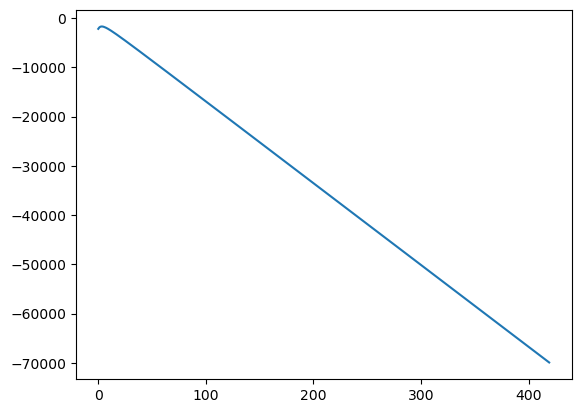

In [39]:
plt.plot(likelihood)
plt.show()

/var/folders/8r/sf09gm417452y_p81bzf8kp00000gn/T/ipykernel_33572/36118581.py:8: RuntimeWarning: overflow encountered in exp
  return np.exp(z)/(1+np.exp(z))
/var/folders/8r/sf09gm417452y_p81bzf8kp00000gn/T/ipykernel_33572/36118581.py:8: RuntimeWarning: invalid value encountered in divide
  return np.exp(z)/(1+np.exp(z))
/var/folders/8r/sf09gm417452y_p81bzf8kp00000gn/T/ipykernel_33572/36118581.py:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(h))
/Users/alexzhou/miniconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


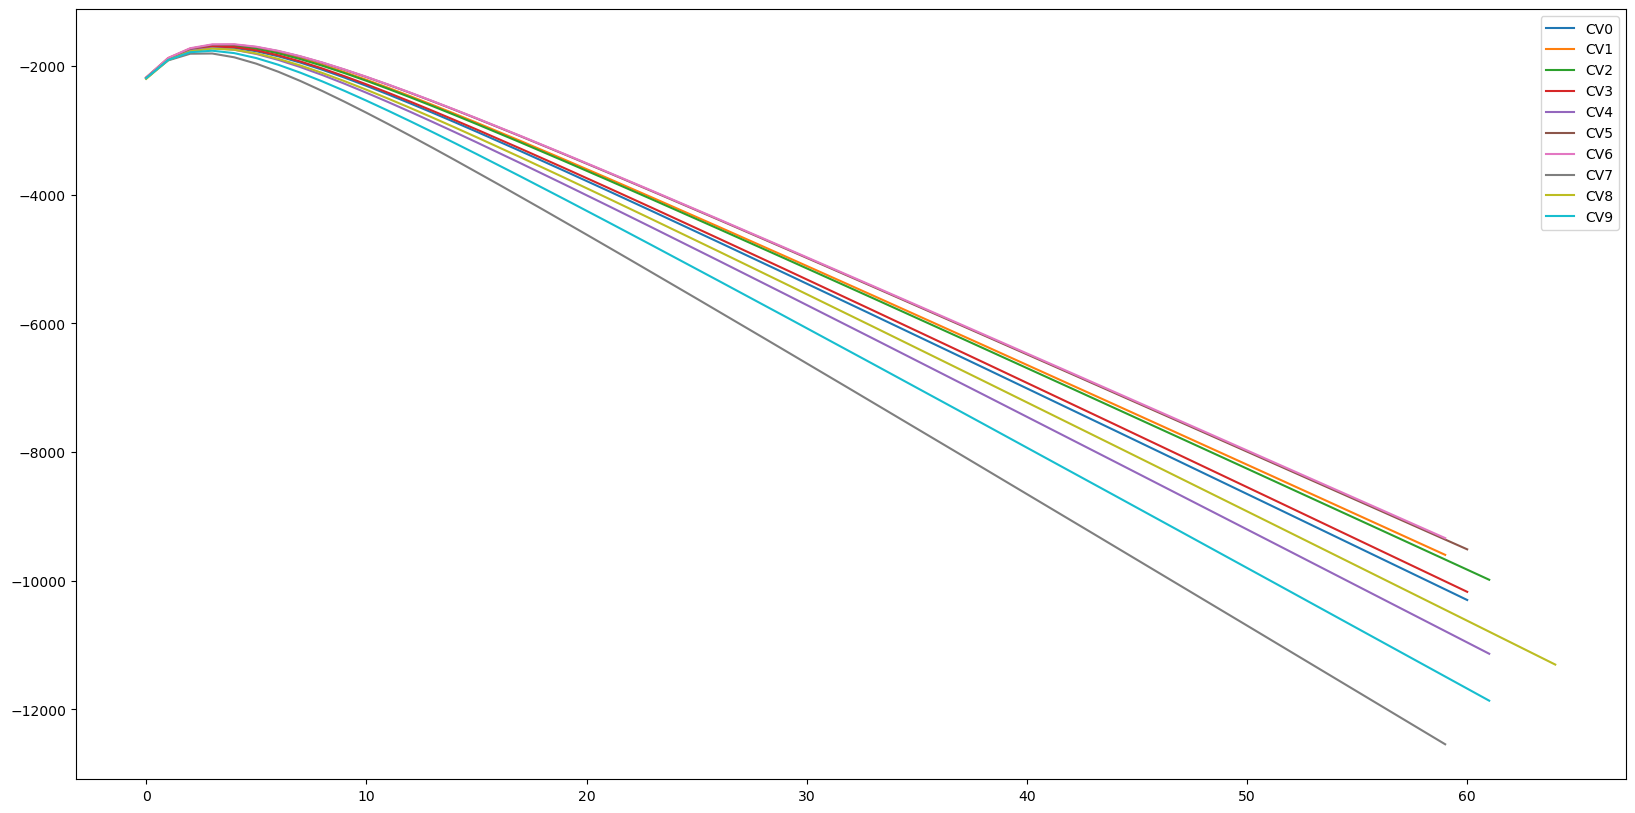

Accuracy:  0.7878260869565217


In [36]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Logistic_Regression(learning_rate = 0.01/4600, n_iter = 1000)
    likelihood = nb_model.fit(X_train, y_train)
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)

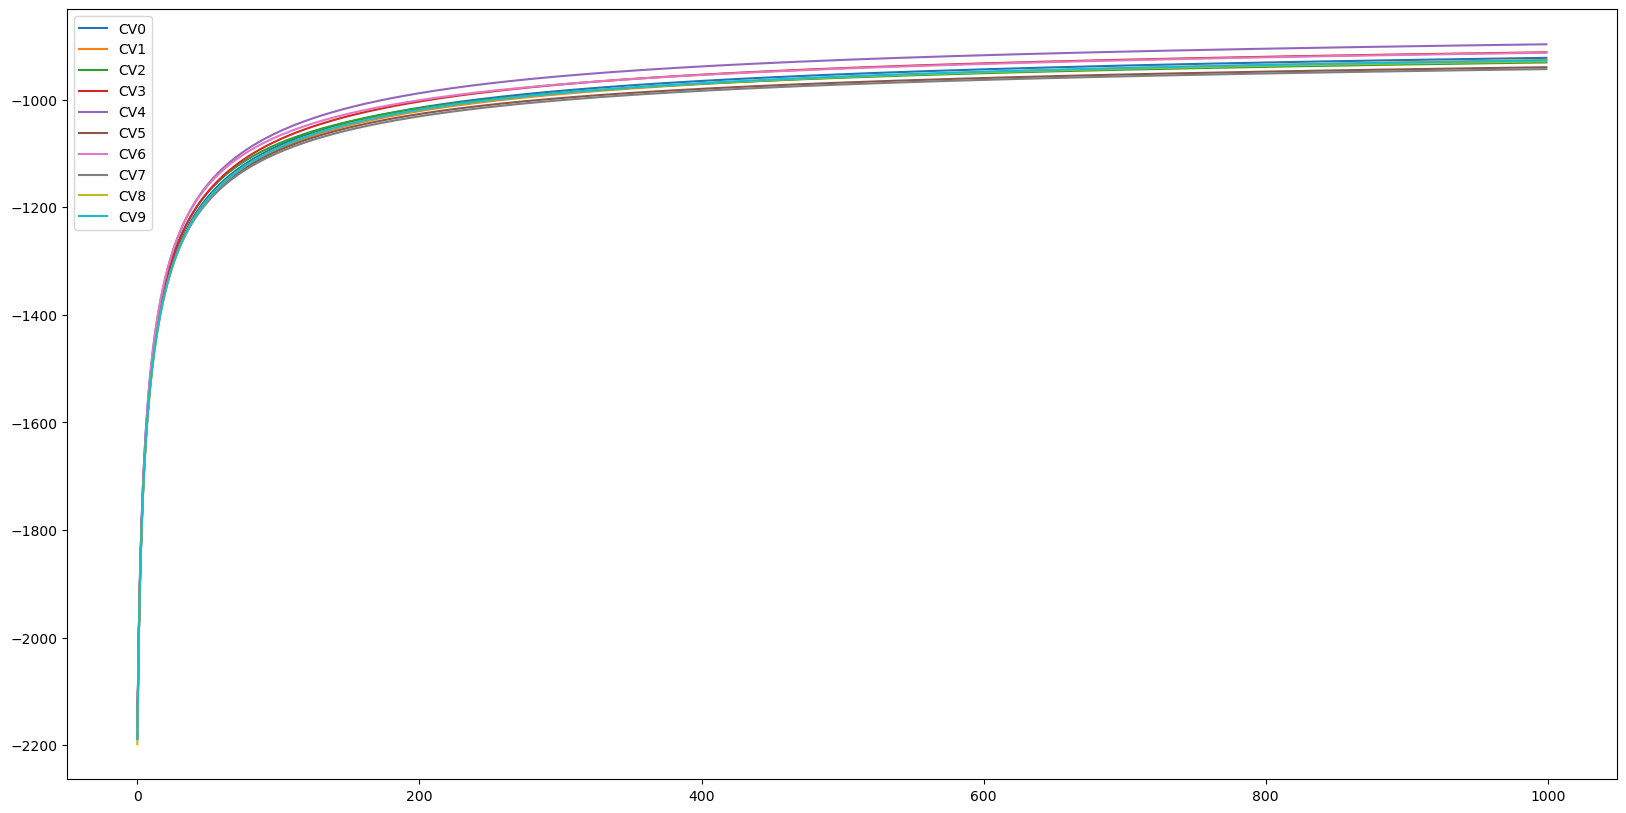

Accuracy:  0.9267391304347825


In [35]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = LogisticRegression(learning_rate = 0.01/4600, n_iters = 1000)
    likelihood = nb_model.fit(X_train, y_train)
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)


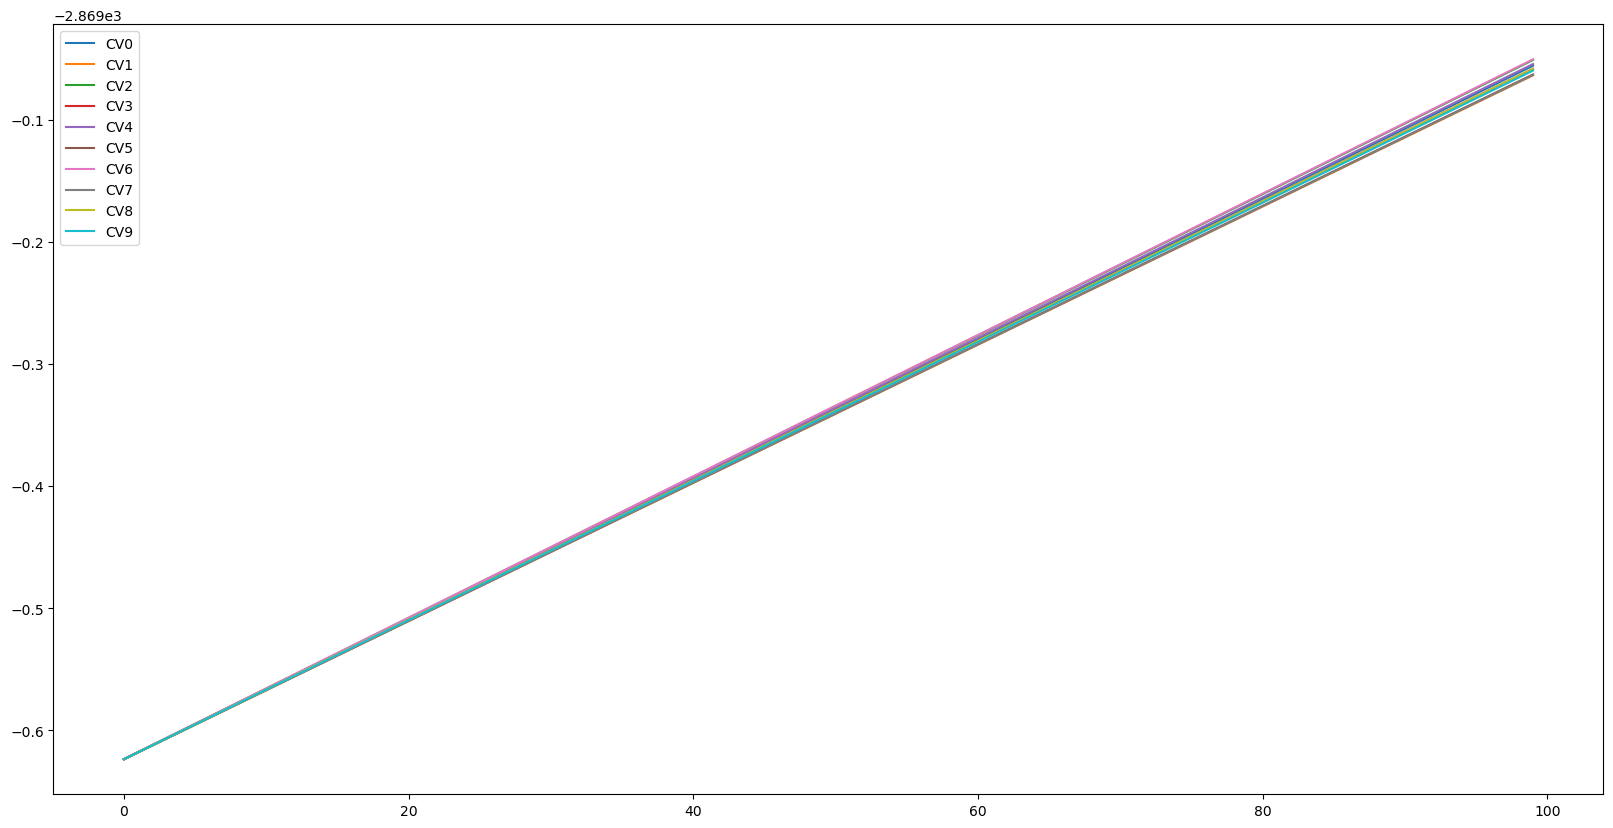

Accuracy:  0.8843478260869565
-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1415            134 
 Predicted 0      398             2653 
-------------------------------------


In [40]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Logistic_Regression(learning_rate = 0.01, n_iter = 100)
    likelihood = nb_model.fit(X_train, y_train, 'newton')
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, y_predicted)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))

### Probelm3

### (a)

In [88]:
X_train = pd.read_csv("Gaussian_process/X_train.csv", header=None).to_numpy()
y_train = pd.read_csv("Gaussian_process/y_train.csv", header=None).to_numpy()
X_test = pd.read_csv("Gaussian_process/X_test.csv", header=None).to_numpy()
y_test = pd.read_csv("Gaussian_process/y_test.csv", header=None).to_numpy()

In [156]:
class Gaussian_Process:
    def __init__(self, b, sigma) -> None:
        self.kernel = None
        self.b = b
        self.sigma = sigma
    def cal_kernel(self, X_i, X_j):
        result = np.zeros((X_i.shape[0], X_j.shape[0]))
        for i in range(X_i.shape[0]):
            for j in range(X_j.shape[0]):
                result[i][j] = np.exp(-np.linalg.norm(X_i[i]-X_j[j])/self.b)
        return result
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.kernel = self.cal_kernel(X, X)
        self.kernel_mean = np.linalg.inv(np.eye(self.kernel.shape[0])*self.sigma + self.kernel)
    
    def predict(self, X):
        k = self.cal_kernel(X, self.X)
        return k @ self.kernel_mean @ self.y
    
    def RMSE(self, y_true, y_predict):
        return np.sqrt(np.mean((y_true-y_predict)**2))

In [158]:
result_df = pd.DataFrame()
result_df['b'] = [i/10 for i in range(1,11)]
for b in [5,7,9,11,13,15]:
    rmse_list = []
    for sigma in range(1, 11):
        sigma = sigma/10
        GP_model = Gaussian_Process(b, sigma)
        GP_model.fit(X_train, y_train)
        y_predict = GP_model.predict(X_test)
        rmse_list.append(GP_model.RMSE(y_test, y_predict))
    result_df[b] = rmse_list

5 0.1
1.9383733698402752
5 0.2
1.933603743490147
5 0.3
1.930741097429168
5 0.4
1.930310506388067
5 0.5
1.9315065197285586
5 0.6
1.933780321034594
5 0.7
1.9368058877277778
5 0.8
1.9403883647544287
5 0.9
1.9444071770931954
5 1.0
1.948784354276489
7 0.1
1.9408545249743367
7 0.2
1.934727759242833
7 0.3
1.9331991801454311
7 0.4
1.9344254637917875
7 0.5
1.9371626724475937
7 0.6
1.9408229061063578
7 0.7
1.9451207483366022
7 0.8
1.9499078633803473
7 0.9
1.9551002649400913
7 1.0
1.9606454174938666
9 0.1
1.9415572002286197
9 0.2
1.935957676385042
9 0.3
1.9361298517044914
9 0.4
1.9389068332531363
9 0.5
1.9430011659269202
9 0.6
1.9479165593690448
9 0.7
1.9534426120302815
9 0.8
1.959476912868396
9 0.9
1.965959803985299
9 1.0
1.9728493503046718
11 0.1
1.9416591379462416
11 0.2
1.9373519894374887
11 0.3
1.9391442317971155
11 0.4
1.9432824289255053
11 0.5
1.9486129625399164
11 0.6
1.9547565275360483
11 0.7
1.9615638505295485
11 0.8
1.9689573976942527
11 0.9
1.9768827098648498
11 1.0
1.985293268171484


In [159]:
result_df

,b,5,7,9,11,13,15
0,0.1,1.938373,1.940855,1.941557,1.941659,1.941614,1.941592
1,0.2,1.933604,1.934728,1.935958,1.937352,1.938871,1.940464
2,0.3,1.930741,1.933199,1.936130,1.939144,1.942125,1.945044
3,0.4,1.930311,1.934425,1.938907,1.943282,1.947502,1.951611
4,0.5,1.931507,1.937163,1.943001,1.948613,1.954043,1.959399
5,0.6,1.933780,1.940823,1.947917,1.954757,1.961468,1.968196
6,0.7,1.936806,1.945121,1.953443,1.961564,1.969662,1.977895
7,0.8,1.940388,1.949908,1.959477,1.968957,1.978550,1.988406
8,0.9,1.944407,1.955100,1.965960,1.976883,1.988067,1.999639
9,1.0,1.948784,1.960645,1.972849,1.985293,1.998150,2.011513


In [ ]:
result_df.index = 